# Chest X-Ray Medical Diagnosis with Deep Learning

## Imports

In [1]:
import os

# Set environment variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

2025-02-26 17:14:58.431924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 17:14:58.444477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 17:14:58.448010: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

I0000 00:00:1740590100.181902    1911 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740590100.228365    1911 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740590100.230609    1911 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.17.0')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [4]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [5]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.IMAGES_DIR)

datasets/images-small/


In [6]:
IMAGE_DIR = Path(cfg.DATASET_DIRS.IMAGES_DIR)
TRAIN_CSV = Path(cfg.DATASET_DIRS.TRAIN_CSV)
VALID_CSV = Path(cfg.DATASET_DIRS.VALID_CSV)
TEST_CSV = Path(cfg.DATASET_DIRS.TEST_CSV)


DENSENET_WEIGHT_PATH = cfg.PRETRAIN_MODEL.DENSENET_WEIGHT_PATH



BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
IMAGE_SIZE = cfg.TRAIN.IMG_SIZE

## Load the Datasets
[ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.

### Loading the Data

In [7]:
train_df = pd.read_csv(f"{TRAIN_CSV}")
valid_df = pd.read_csv(f"{VALID_CSV}")

test_df = pd.read_csv(f"{TEST_CSV}")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 non-null   int64 
 6   Emphysema           1000 non-null   int64 
 7   Fibrosis            1000 non-null   int64 
 8   Hernia              1000 non-null   int64 
 9   Infiltration        1000 non-null   int64 
 10  Mass                1000 non-null   int64 
 11  Nodule              1000 non-null   int64 
 12  PatientId           1000 non-null   int64 
 13  Pleural_Thickening  1000 non-null   int64 
 14  Pneumonia           1000 non-null   int64 
 15  Pneumothorax        1000 non-null   int64 
dtypes: int64(15), object(1)
m

### Total Labels

In [9]:
column_names = list(train_df.columns)
labels = column_names[1:]
labels.remove('PatientId')
labels, len(labels)

(['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'],
 14)

In [10]:
train_df_labels = train_df[labels]
train_df_labels.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [11]:
valid_df_labels = valid_df[labels]
test_df_labels = test_df[labels]

## Data Leakage Prevent

check if there are patients in both train and test or in both valid and test.

In [12]:
def check_for_dataleakage(df1, df2, patentId_col='PatientId'):
    """
    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    df1_patients_unique = df1[patentId_col].unique()
    df2_patients_unique = df2[patentId_col].unique()

    patients_in_common = np.intersect1d(df1_patients_unique, df2_patients_unique)

    leakage = True if (len(patients_in_common) > 0) else False
    return leakage

In [13]:
check_for_dataleakage(train_df, valid_df)

True

In [14]:
check_for_dataleakage(train_df, test_df)

False

In [15]:
check_for_dataleakage(test_df, valid_df)

False

### Load Training Dataset from Dataframe

Check for images

In [16]:
IMAGE_DIR

PosixPath('datasets/images-small')

In [17]:
def is_image_exists(df):

    temp_df = df.copy() 
    for idx, image_path in enumerate(df.Image.values):
        # tf.io.read_file(f"{IMAGE_DIR/image_path}")
        if not Path(f"{IMAGE_DIR/image_path}").exists():
            print(f"Image {IMAGE_DIR/image_path} does not exist :{idx=}")
            temp_df = temp_df.drop(idx)

    return temp_df

In [18]:
len(is_image_exists(valid_df))

200

In [19]:
def load_image(image_name, label):
    full_path = tf.strings.join([f'{IMAGE_DIR}/', image_name])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Resize to the desired size
    label = tf.cast(label, tf.float32)
    return image, label


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_df.Image.values,  train_df_labels.values))
train_ds = train_ds.map(load_image, num_parallel_calls=-1)

I0000 00:00:1740590101.752302    1911 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740590101.754841    1911 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740590101.756750    1911 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740590101.878499    1911 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [21]:
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df.Image.values,  valid_df_labels.values))
valid_ds = valid_ds.map(load_image, num_parallel_calls=-1)

In [22]:
for batch in train_ds.take(1):
    image, label = batch
    print(image, label)

tf.Tensor(
[[[203.48     203.48     203.48    ]
  [194.97     194.97     194.97    ]
  [184.2      184.2      184.2     ]
  ...
  [192.       192.       192.      ]
  [200.63004  200.63004  200.63004 ]
  [212.6003   212.6003   212.6003  ]]

 [[144.91     144.91     144.91    ]
  [120.09     120.09     120.09    ]
  [101.35     101.35     101.35    ]
  ...
  [173.45     173.45     173.45    ]
  [188.31     188.31     188.31    ]
  [201.90022  201.90022  201.90022 ]]

 [[ 86.350006  86.350006  86.350006]
  [ 59.35      59.35      59.35    ]
  [ 41.5       41.5       41.5     ]
  ...
  [126.5      126.5      126.5     ]
  [173.50012  173.50012  173.50012 ]
  [191.2002   191.2002   191.2002  ]]

 ...

 [[ 13.45      13.45      13.45    ]
  [ 10.049999  10.049999  10.049999]
  [  8.         8.         8.      ]
  ...
  [ 13.75      13.75      13.75    ]
  [ 19.25003   19.25003   19.25003 ]
  [ 30.300049  30.300049  30.300049]]

 [[ 14.929998  14.929998  14.929998]
  [ 11.190008  11.190008  

## Image Processing

In [23]:
## TODO: try out sample wise normalization instead of whole datasets
normalized_layer = tf.keras.layers.Normalization()
normalized_layer.adapt(train_ds.map(lambda x, y: x))

'''+ptx85+ptx85' is not a recognized feature for this target' is not a recognized feature for this target (ignoring feature)
+ptx85 (ignoring feature)
' is not a recognized feature for this target (ignoring feature)
'+ptx85'' is not a recognized feature for this target (ignoring feature)
'+ptx85+ptx85' is not a recognized feature for this target' is not a recognized feature for this target (ignoring feature)
 (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

In [24]:
train_ds = train_ds.map(lambda x, y: (normalized_layer(x), y))
train_ds = train_ds.batch(BATCH_SIZE).shuffle(BATCH_SIZE*4)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

In [25]:
for batch in train_ds.take(1):
    image, label = batch
    print(image, label)

tf.Tensor(
[[[[-1.4245863e+00 -1.4245863e+00 -1.4245863e+00]
   [-1.3827851e+00 -1.3827851e+00 -1.3827851e+00]
   [-1.3066247e+00 -1.3066247e+00 -1.3066247e+00]
   ...
   [-1.9961852e+00 -1.9961852e+00 -1.9961852e+00]
   [-1.9961852e+00 -1.9961852e+00 -1.9961852e+00]
   [-1.9961852e+00 -1.9961852e+00 -1.9961852e+00]]

  [[-1.3280003e+00 -1.3280003e+00 -1.3280003e+00]
   [-1.3153332e+00 -1.3153332e+00 -1.3153332e+00]
   [-1.2955410e+00 -1.2955410e+00 -1.2955410e+00]
   ...
   [-1.9961852e+00 -1.9961852e+00 -1.9961852e+00]
   [-1.9961852e+00 -1.9961852e+00 -1.9961852e+00]
   [-1.9961852e+00 -1.9961852e+00 -1.9961852e+00]]

  [[-1.2622901e+00 -1.2622901e+00 -1.2622901e+00]
   [-1.2702070e+00 -1.2702070e+00 -1.2702070e+00]
   [-1.2242891e+00 -1.2242891e+00 -1.2242891e+00]
   ...
   [-1.9961852e+00 -1.9961852e+00 -1.9961852e+00]
   [-1.9961852e+00 -1.9961852e+00 -1.9961852e+00]
   [-1.9961852e+00 -1.9961852e+00 -1.9961852e+00]]

  ...

  [[ 1.2172778e+00  1.2172778e+00  1.2172778e+00]
   [ 

In [26]:
valid_ds = valid_ds.map(lambda x, y: (normalized_layer(x), y))
valid_ds = valid_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

## Model Development

### Class Imbalance Handling

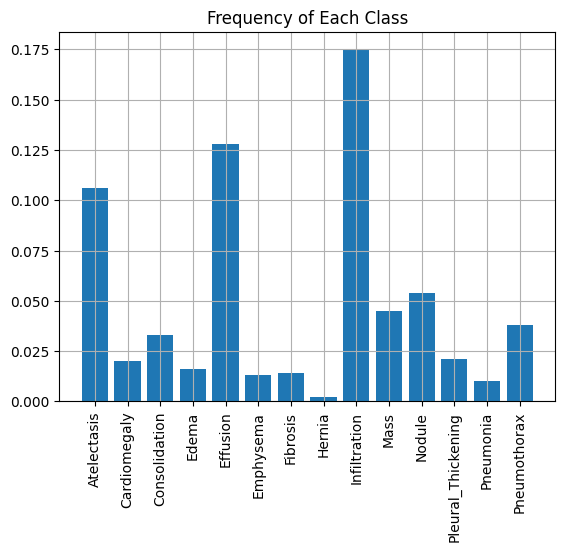

In [27]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_df_labels, axis=0))
plt.title("Frequency of Each Class")
plt.grid()
plt.show()

### Compute Class Frequencies

In [28]:

N = train_df_labels.shape[0]
positive_frequencies = (train_df_labels==1).sum()/N
negative_frequencies = (train_df_labels==0).sum()/N
positive_frequencies, negative_frequencies

(Atelectasis           0.106
 Cardiomegaly          0.020
 Consolidation         0.033
 Edema                 0.016
 Effusion              0.128
 Emphysema             0.013
 Fibrosis              0.014
 Hernia                0.002
 Infiltration          0.175
 Mass                  0.045
 Nodule                0.054
 Pleural_Thickening    0.021
 Pneumonia             0.010
 Pneumothorax          0.038
 dtype: float64,
 Atelectasis           0.894
 Cardiomegaly          0.980
 Consolidation         0.967
 Edema                 0.984
 Effusion              0.872
 Emphysema             0.987
 Fibrosis              0.986
 Hernia                0.998
 Infiltration          0.825
 Mass                  0.955
 Nodule                0.946
 Pleural_Thickening    0.979
 Pneumonia             0.990
 Pneumothorax          0.962
 dtype: float64)

In [29]:
data_df = pd.DataFrame(list(positive_frequencies.items()), columns=['class', 'positives'])
data_df['negatives'] = negative_frequencies.values
data_df

,class,positives,negatives
0,Atelectasis,0.106,0.894
1,Cardiomegaly,0.020,0.980
2,Consolidation,0.033,0.967
3,Edema,0.016,0.984
4,Effusion,0.128,0.872
5,Emphysema,0.013,0.987
6,Fibrosis,0.014,0.986
7,Hernia,0.002,0.998
8,Infiltration,0.175,0.825
9,Mass,0.045,0.955


<Axes: xlabel='class'>

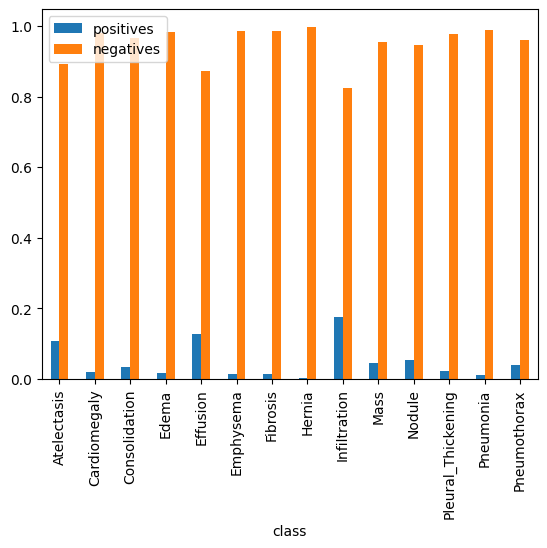

In [30]:
data_df.plot.bar(x='class')

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [31]:
pos_weights = negative_frequencies
neg_weights = positive_frequencies

pos_contirbution = positive_frequencies * pos_weights
neg_contribution = negative_frequencies * neg_weights

pos_contirbution, neg_contribution

(Atelectasis           0.094764
 Cardiomegaly          0.019600
 Consolidation         0.031911
 Edema                 0.015744
 Effusion              0.111616
 Emphysema             0.012831
 Fibrosis              0.013804
 Hernia                0.001996
 Infiltration          0.144375
 Mass                  0.042975
 Nodule                0.051084
 Pleural_Thickening    0.020559
 Pneumonia             0.009900
 Pneumothorax          0.036556
 dtype: float64,
 Atelectasis           0.094764
 Cardiomegaly          0.019600
 Consolidation         0.031911
 Edema                 0.015744
 Effusion              0.111616
 Emphysema             0.012831
 Fibrosis              0.013804
 Hernia                0.001996
 Infiltration          0.144375
 Mass                  0.042975
 Nodule                0.051084
 Pleural_Thickening    0.020559
 Pneumonia             0.009900
 Pneumothorax          0.036556
 dtype: float64)

In [32]:
weighted_data_df = pd.DataFrame(list(pos_contirbution.items()), columns=['class', 'positives'])
weighted_data_df['negatives'] = neg_contribution.values
weighted_data_df

,class,positives,negatives
0,Atelectasis,0.094764,0.094764
1,Cardiomegaly,0.019600,0.019600
2,Consolidation,0.031911,0.031911
3,Edema,0.015744,0.015744
4,Effusion,0.111616,0.111616
5,Emphysema,0.012831,0.012831
6,Fibrosis,0.013804,0.013804
7,Hernia,0.001996,0.001996
8,Infiltration,0.144375,0.144375
9,Mass,0.042975,0.042975


<Axes: xlabel='class'>

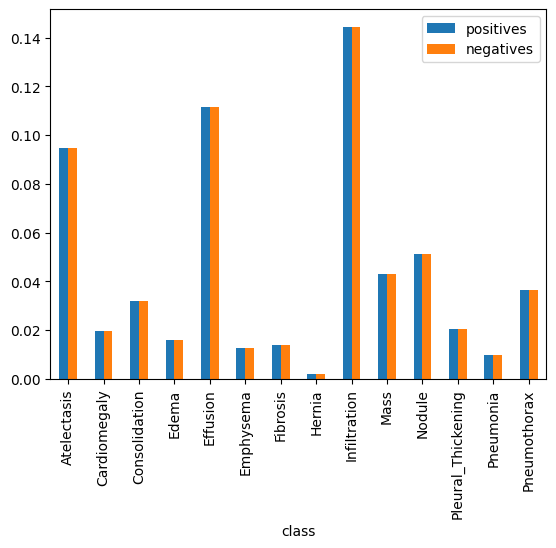

In [33]:
weighted_data_df.plot.bar(x='class')

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [34]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            y = y_true[:, i]
            f_of_x = y_pred[:, i]

            f_of_x_log = K.log(f_of_x + epsilon)
            f_of_x_1_min_log = K.log((1-f_of_x) + epsilon)

            first_term = pos_weights[i] * y * f_of_x_log
            sec_term = neg_weights[i] * (1-y) * f_of_x_1_min_log
            loss_per_col = - K.mean(first_term + sec_term)
            loss += loss_per_col
        return loss

    return weighted_loss


## Load and Prepare DenseNet121 Model

In [35]:
tf.keras.backend.clear_session()

LEARNING_RATE = 0.001

base_model = tf.keras.applications.DenseNet121(
     include_top=False,
     weights=DENSENET_WEIGHT_PATH, #'imagenet',
     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)  
)
x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
               loss=get_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy'])     

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 326, 326, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 160, 160, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1/conv[0][0]']      

## Model training

In [36]:
import math
# Get the length of the training set
length_of_training_dataset = len(train_df)

# Get the length of the validation set
length_of_validation_dataset = len(valid_df)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = math.ceil(length_of_training_dataset/BATCH_SIZE)

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = math.ceil(length_of_validation_dataset/BATCH_SIZE)
validation_steps

13

## Callbacks

In [37]:
CHECK_POINT_DIR = cfg.OUTPUTS.CHECKPOINT_PATH
checkpoint_prefix = os.path.join(CHECK_POINT_DIR, "ckpt_{epoch}")
LOG_DIR = cfg.OUTPUTS.LOG_DIR

In [38]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True,
                                        save_best_only=True,
                                        monitor='val_loss',
                                        mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
]

In [39]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=validation_steps, 
                    epochs = 100,
                    callbacks=callbacks)


Epoch 1/100


/tmp/__autograph_generated_filegewr2fxx.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_term = ag__.ld(pos_weights)[ag__.ld(i)] * ag__.ld(y) * ag__.ld(f_of_x_log)
/tmp/__autograph_generated_filegewr2fxx.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sec_term = ag__.ld(neg_weights)[ag__.ld(i)] * (1 - ag__.ld(y)) * ag__.ld(f_of_x_1_min_log)
W0000 00:00:1740590134.904092    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590134.929224    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590134.929

 1/63 [..............................] - ETA: 45:30 - loss: 0.8419 - accuracy: 0.0625

W0000 00:00:1740590153.399152    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590153.399752    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590153.400749    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590153.402300    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590153.403779    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590153.404681    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590153.405647    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590153.406761    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590153.408445    2030 gp

 2/63 [..............................] - ETA: 1:12 - loss: 0.9633 - accuracy: 0.0312 

W0000 00:00:1740590154.408994    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590154.409415    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590154.409992    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590154.413730    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590154.413929    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590154.414025    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590154.414121    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590154.414286    2034 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590154.414463    2034 gp

38/63 [=================>............] - ETA: 3s - loss: 0.9331 - accuracy: 0.0609

W0000 00:00:1740590158.894825    2040 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590158.895140    2040 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590158.895446    2040 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590158.895843    2040 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590158.896238    2040 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590158.896699    2040 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590158.897191    2040 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590158.897753    2040 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590158.898326    2040 gp

39/63 [=================>............] - ETA: 4s - loss: 0.9291 - accuracy: 0.0601

W0000 00:00:1740590160.515577    2032 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590160.515952    2032 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590160.516383    2032 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590160.516850    2032 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590160.517413    2032 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590160.518556    2032 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590160.519517    2032 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590160.520048    2032 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590160.520615    2032 gp

63/63 [==============================] - ETA: 0s - loss: 0.9075 - accuracy: 0.0460

W0000 00:00:1740590165.171005    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590165.171646    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590165.173005    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590165.173839    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590165.181782    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590165.182718    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590165.225346    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590165.226469    2030 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1740590165.227928    2030 gp

63/63 [==============================] - 58s 218ms/step - loss: 0.9075 - accuracy: 0.0460 - val_loss: 8.9189 - val_accuracy: 0.0300 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 10s 151ms/step - loss: 0.8672 - accuracy: 0.0280 - val_loss: 7.2644 - val_accuracy: 0.0650 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 9s 135ms/step - loss: 0.8212 - accuracy: 0.0440 - val_loss: 0.9090 - val_accuracy: 0.0600 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 8s 123ms/step - loss: 0.8008 - accuracy: 0.0460 - val_loss: 1.0410 - val_accuracy: 0.0150 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - 8s 121ms/step - loss: 0.7813 - accuracy: 0.0720 - val_loss: 4.6140 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 9s 124ms/step - loss: 0.7770 - accuracy: 0.0560 - val_loss: 2.0032 - val_accuracy: 0.0700 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - 9s 136ms/step - loss:

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Training Accuracy Curve")
plt.show()